In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.graph_objects as go

In [3]:
# Import venue data within 1km of each neighborhood
venue_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_venues_data_1km.csv')
venue_data.head()

,id,accounting,aquarium,art_gallery,bakery,bank,bar,beauty_salon,bicycle_store,book_store,...,store,subway_station,supermarket,synagogue,tourist_attraction,transit_station,travel_agency,university,veterinary_care,zoo
0,nyu_2451_34572.1,1,0,0,1,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,nyu_2451_34572.10,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,nyu_2451_34572.100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,nyu_2451_34572.101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,nyu_2451_34572.102,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [12]:
# Create function to find the most common venues per neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [14]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['id'] = venue_data['id']

for ind in np.arange(venue_data.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_data.iloc[ind, :], num_top_venues)

In [15]:
venues_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,school,secondary_school,bank,plumber,drugstore
1,nyu_2451_34572.10,secondary_school,funeral_home,church,lodging,school
2,nyu_2451_34572.100,doctor,dentist,car_dealer,restaurant,drugstore
3,nyu_2451_34572.101,lodging,cafe,museum,plumber,place_of_worship
4,nyu_2451_34572.102,restaurant,park,church,real_estate_agency,travel_agency


In [8]:
# Import neighborhood data
neighborhood_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/old_dataset.csv')
neighborhood_data = neighborhood_data.iloc[:, 1:6]
neighborhood_data.head()

,id,borough,neighborhood,longitude,latitude
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834


In [9]:
# Drop neighborhood ID to create numerical data for k-means clustering
venue_clustering = venue_data.drop('id', axis=1)

In [10]:
# Create elbow graph function
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

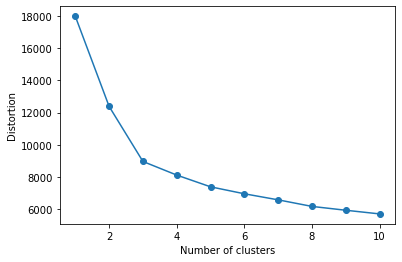

In [11]:
# Plot elbow graph
plot_distortion(venue_clustering)

In [16]:
# Cluster data points using kmeans and get labels
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_clustering)

kmeans.labels_[0:10] 

array([0, 0, 1, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

In [18]:
# Add cluster labels to venue data
venues_sorted.insert(0, 'clusters', kmeans.labels_)
clusters = venues_sorted.clusters.tolist()
venues_sorted = venues_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_data = neighborhood_data.copy()
all_data = pd.merge(all_data, venues_sorted, on='id')
all_data['clusters'] = clusters

all_data.head()

,id,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705,school,secondary_school,bank,plumber,drugstore,0
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294,health,secondary_school,department_store,dentist,school,0
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556,health,car_repair,primary_school,restaurant,storage,1
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437,school,synagogue,restaurant,dentist,church,2
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834,health,cafe,school,veterinary_care,university,0


# Mapping

In [21]:
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

In [22]:
# Create a map of new york

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [25]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_data['latitude'], all_data['longitude'], all_data['neighborhood'],all_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters